# Morgan Fingerprint + Feedforward Neural Network

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
import numpy as np
from tdc.single_pred import Tox
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors, PandasTools
import pandas as pd
from sklearn.dummy import DummyRegressor
from sklearn.metrics import explained_variance_score, max_error, \
                     mean_absolute_error, mean_squared_error, r2_score

In [3]:
data = Tox(name='LD50_Zhu').get_data()

Found local copy...
Loading...
Done!


In [4]:
data

,Drug_ID,Drug,Y
0,"Diazene, diphenyl-, 1-oxide",[O-][N+](=Nc1ccccc1)c1ccccc1,2.505
1,"Methane, tribromo-",BrC(Br)Br,2.343
2,Bromoethene (9CI),C=CBr,2.330
3,"1,1'-Biphenyl, hexabromo-",Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.465
4,"Isothiocyanic acid, p-bromophenyl ester",S=C=Nc1ccc(Br)cc1,2.729
...,...,...,...
7380,"Isocyanic acid, (alpha,alpha,alpha-trifluoro-o...",O=C=Nc1ccccc1C(F)(F)F,1.427
7381,"1,3-Benzenediamine, 4-(1,1,2,2-tetrafluoroetho...",Nc1ccc(OC(F)(F)C(F)F)c(N)c1,2.321
7382,"Propanenitrile, 3-((2-(acetyloxy)ethyl)phenyla...",CC(=O)OCCN(CCC#N)c1ccccc1,2.050
7383,"IH-Indene-1,3(2H)-dione, 2-(2-methyl-1-(2-(1-p...",CC1=CC(=C2C(=O)c3ccccc3C2=O)C=CN1CCN1CCCCC1,2.951


In [5]:
PandasTools.AddMoleculeColumnToFrame(data,'Drug','Molecule')
if data.Molecule.isna().sum()==0:
    print('Smiles loaded')

Smiles loaded


,Drug_ID,Drug,Y,Molecule
25,"2-Propenamide, N,N'-methylenebis-",C=CC(=O)NCNC(=O)C=C,2.597,

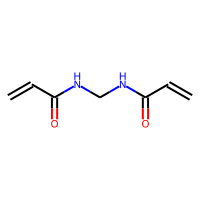

In [6]:
data.sample(1)

In [7]:
# this function makes transform SMILES -> Morgan Fingerprint
def morgan_fp_old_unused(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [8]:
# this function makes transform SMILES -> Morgan Fingerprint + Descriptors
def morgan_fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)

    d = [
        # add other descriptors if necessary
        # https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html
        Descriptors.MolLogP(mol),
        Descriptors.MolMR(mol), 
        Descriptors.MolWt(mol),
        Descriptors.ExactMolWt(mol),
        Descriptors.BalabanJ(mol), 
        Descriptors.NumHAcceptors(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumValenceElectrons(mol),
        Descriptors.HeavyAtomCount(mol),
        Descriptors.HeavyAtomMolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.FpDensityMorgan1(mol),
        Descriptors.FpDensityMorgan2(mol),
        Descriptors.FpDensityMorgan3(mol),
        Descriptors.MaxAbsPartialCharge(mol),
        Descriptors.MaxPartialCharge(mol),
        Descriptors.MinAbsPartialCharge(mol),
        Descriptors.MinPartialCharge(mol),
        Descriptors.NumRadicalElectrons(mol),
        Descriptors.NumValenceElectrons(mol),
        rdMolDescriptors.CalcChi0n(mol),
        rdMolDescriptors.CalcChi0v(mol),
        rdMolDescriptors.CalcChi1n(mol),
        rdMolDescriptors.CalcChi1v(mol),
        rdMolDescriptors.CalcChi2n(mol),
        rdMolDescriptors.CalcChi2v(mol),
        rdMolDescriptors.CalcChi3n(mol),
        rdMolDescriptors.CalcChi3v(mol),
        rdMolDescriptors.CalcChi4n(mol),
        rdMolDescriptors.CalcChi4v(mol),
        rdMolDescriptors.CalcKappa1(mol),
        rdMolDescriptors.CalcKappa2(mol),
        rdMolDescriptors.CalcKappa3(mol),
        rdMolDescriptors.CalcLabuteASA(mol)
        ]
    
    ar2 = np.array(d)
    
    return np.concatenate((ar, ar2))

In [9]:
data["Morgan_FP"] = data.Molecule.apply(morgan_fp)

,Drug_ID,Drug,Y,Molecule,Morgan_FP
6476,"Pyrimidine, 1,4,5,6-tetrahydro-1-methyl-2-(2-(...",CN1CCCN=C1C=Cc1cccs1,3.084,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."

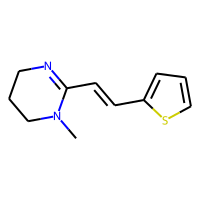

In [10]:
data.sample(1)

In [11]:
X = np.stack(data.Morgan_FP.values)
print(X.shape)

(7385, 4130)


In [12]:
y = data.Y.values.reshape((-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

In [13]:
# Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [14]:
feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
X_validation = feature_select.transform(X_validation)
X_test = feature_select.transform(X_test)
X_train.shape

(6313, 191)

In [15]:
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_train

cpu


tensor([[  0.0000,   0.0000,   0.0000,  ...,   5.6214,   1.8404, 195.7904],
        [  0.0000,   0.0000,   0.0000,  ...,   3.1069,   1.2095,  60.3884],
        [  0.0000,   0.0000,   0.0000,  ...,   5.6099,   2.4171, 153.8326],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   2.9260,   1.9497,  65.7475],
        [  0.0000,   0.0000,   0.0000,  ...,   5.3904,   3.2736,  90.4460],
        [  0.0000,   0.0000,   0.0000,  ...,   4.1709,   1.8603,  88.9605]])

In [16]:
X_train.shape

torch.Size([6313, 191])

### Model's Hyperparameters

In [1]:
hidden_size = 512
dropout_rate = 0.7
learning_rate = 0.001
epochs = 200
batch_size=256

In [17]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [18]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size=1):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size)

        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size) 
        
        self.activation = nn.LeakyReLU()
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc_out(out)
        return out

In [19]:
input_size = X_train.size()[-1]
model = Net(input_size, hidden_size, dropout_rate)

In [20]:
#model.cuda()
model

Net(
  (fc1): Linear(in_features=191, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc_out): Linear(in_features=512, out_features=1, bias=True)
  (ln1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.7, inplace=False)
)

In [21]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
model.train()

train_losses = []
validation_losses = []

for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        optimizer.zero_grad()
        output = model(fps)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
         
        running_loss += loss.item()
    else:
        validation_loss = torch.mean(( y_validation - model(X_validation) )**2).item()
        print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,
                                                                        (running_loss/len(train_loader)), 
                                                                        validation_loss))
        train_losses.append(running_loss/len(train_loader))
        validation_losses.append(validation_loss)

Epoch:   0 Training loss: 1.24 Validation loss: 1.00
Epoch:   1 Training loss: 1.03 Validation loss: 0.95
Epoch:   2 Training loss: 1.00 Validation loss: 0.96
Epoch:   3 Training loss: 1.01 Validation loss: 0.96
Epoch:   4 Training loss: 0.97 Validation loss: 0.86
Epoch:   5 Training loss: 0.91 Validation loss: 0.85
Epoch:   6 Training loss: 0.84 Validation loss: 0.81
Epoch:   7 Training loss: 0.82 Validation loss: 0.76
Epoch:   8 Training loss: 0.81 Validation loss: 0.76
Epoch:   9 Training loss: 0.78 Validation loss: 0.76
Epoch:  10 Training loss: 0.77 Validation loss: 0.79
Epoch:  11 Training loss: 0.77 Validation loss: 0.71
Epoch:  12 Training loss: 0.76 Validation loss: 0.75
Epoch:  13 Training loss: 0.75 Validation loss: 0.68
Epoch:  14 Training loss: 0.75 Validation loss: 0.73
Epoch:  15 Training loss: 0.72 Validation loss: 0.72
Epoch:  16 Training loss: 0.74 Validation loss: 0.65
Epoch:  17 Training loss: 0.72 Validation loss: 0.70
Epoch:  18 Training loss: 0.71 Validation loss

Epoch: 155 Training loss: 0.53 Validation loss: 0.51
Epoch: 156 Training loss: 0.53 Validation loss: 0.55
Epoch: 157 Training loss: 0.54 Validation loss: 0.51
Epoch: 158 Training loss: 0.53 Validation loss: 0.54
Epoch: 159 Training loss: 0.54 Validation loss: 0.59
Epoch: 160 Training loss: 0.54 Validation loss: 0.52
Epoch: 161 Training loss: 0.53 Validation loss: 0.53
Epoch: 162 Training loss: 0.53 Validation loss: 0.47
Epoch: 163 Training loss: 0.53 Validation loss: 0.55
Epoch: 164 Training loss: 0.54 Validation loss: 0.47
Epoch: 165 Training loss: 0.53 Validation loss: 0.51
Epoch: 166 Training loss: 0.53 Validation loss: 0.51
Epoch: 167 Training loss: 0.54 Validation loss: 0.52
Epoch: 168 Training loss: 0.53 Validation loss: 0.51
Epoch: 169 Training loss: 0.54 Validation loss: 0.51
Epoch: 170 Training loss: 0.53 Validation loss: 0.54
Epoch: 171 Training loss: 0.52 Validation loss: 0.49
Epoch: 172 Training loss: 0.53 Validation loss: 0.53
Epoch: 173 Training loss: 0.53 Validation loss

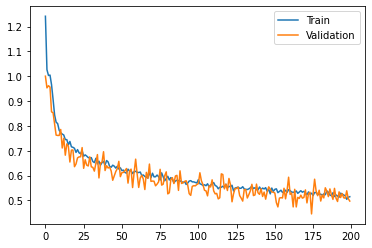

In [23]:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
plt.legend()
plt.show()

In [24]:
model.eval()

y_pred_train = model(X_train)
y_pred_validation = model(X_validation)
y_pred_test = model(X_test)

In [25]:
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()

y_true=flatten(y_test)
y_pred=flatten(y_pred_test)

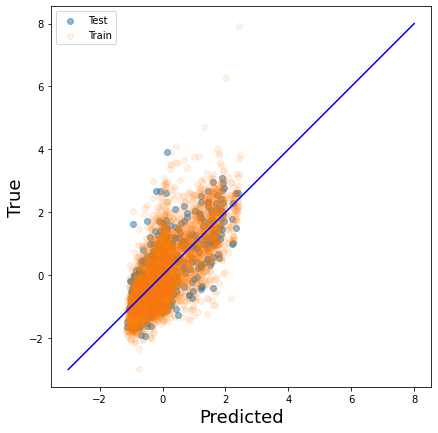

In [26]:
plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
plt.legend()
plt.plot([-3, 8], [-3,8], c="b")
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('True', fontsize=18)

plt.axis('square')
fig = plt.gcf()
fig.set_size_inches(7, 7)

# Make prediction for a single molecule

In [27]:
def predict_smiles(smiles):
    fp = morgan_fp(Chem.MolFromSmiles(smiles)).reshape(1, -1)
    fp_filtered = feature_select.transform(fp)
    fp_tensor = torch.tensor(fp_filtered, device=device).float()
    prediction = model(fp_tensor)
    ld50 = scaler.inverse_transform(prediction.cpu().detach().numpy())
    return ld50[0][0]

In [28]:
predict_smiles('CC1=CC(=C2C(=O)c3ccccc3C2=O)C=CN1CCN1CCCCC1')
# should be about ~2.9

2.6658561

# Model assessment

In [29]:
def assess_model(y_true, y_pred, X_train, y_train):

    def calc_metrics(y_pred):
        score1 = max_error(y_true, y_pred)
        score2 = mean_absolute_error(y_true, y_pred)
        score3 = mean_squared_error(y_true, y_pred)
        score4 = explained_variance_score(y_true, y_pred)
        score5 = r2_score(y_true, y_pred)
        return score1,score2,score3,score4,score5

    dummy1 = DummyRegressor(strategy="mean")
    dummy1.fit(X_train, y_train)
    dummy_mean = dummy1.predict(X_test)

    dummy2 = DummyRegressor(strategy="median")
    dummy2.fit(X_train, y_train)
    dummy_median = dummy2.predict(X_test)

    dummy3 = DummyRegressor(strategy="quantile", quantile=0.0)
    dummy3.fit(X_train, y_train)
    dummy_quantile00 = dummy3.predict(X_test)

    dummy4 = DummyRegressor(strategy="quantile", quantile=0.5)
    dummy4.fit(X_train, y_train)
    dummy_quantile05 = dummy4.predict(X_test)

    dummy5 = DummyRegressor(strategy="quantile", quantile=1.0)
    dummy5.fit(X_train, y_train)
    dummy_quantile10 = dummy5.predict(X_test)
    
    results = [
        calc_metrics(y_pred),
        calc_metrics(dummy_mean),
        calc_metrics(dummy_median),
        calc_metrics(dummy_quantile00),
        calc_metrics(dummy_quantile05),
        calc_metrics(dummy_quantile10)
    ]

    df = pd.DataFrame(results).T 

    df.columns = ['Model', 'dummy(Mean)', 'dummy(Median)', 
                  'dummy(Min Quantile)', 'dummy(Median Quantile)', 
                  'dummy(Max Quantile)']

    df = df.rename(index={0: "max error", 1: "MAE", 2: "MSE", 3:"explained", 4:"r2"})
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    df = df.T

    def highlight_max(data, color='lightgreen'):
        attr = 'background-color: {}'.format(color)
        if data.ndim == 1:  
            is_max = data == data.max()
            return [attr if v else '' for v in is_max]

    def highlight_min(data, color='lightgreen'):
        attr = 'background-color: {}'.format(color)
        if data.ndim == 1:  
            is_min = data == data.min()
            return [attr if v else '' for v in is_min]


    return df.style.apply(highlight_min, subset=['max error', 'MAE', 'MSE']).\
             apply(highlight_max, subset=['explained', 'r2'])

In [30]:
print("\n"+"Morgan FP")
print("VarianceThreshold(0.05)")
print("FeedForwardNN(epochs=200, hidden_size=512, dropout=0.70, lr=0.001)")
assess_model(y_true, y_pred, X_train, y_train)


Morgan FP
VarianceThreshold(0.05)
FeedForwardNN(epochs=200, hidden_size=512, dropout=0.70, lr=0.001)


,max error,MAE,MSE,explained,r2
Model,3.781245,0.498380,0.438224,0.503418,0.503213
dummy(Mean),3.923546,0.741133,0.883702,0.000000,-0.001798
dummy(Median),4.106296,0.717601,0.902543,0.000000,-0.023156
dummy(Min Quantile),6.916358,2.952983,9.602224,-0.000000,-9.885442
dummy(Median Quantile),4.106296,0.717601,0.902543,-0.000000,-0.023156
dummy(Max Quantile),9.860083,7.978488,64.538391,-0.000000,-72.163150


# Well, this model certainly gives better predictions than any dummy model